# Statistical Arbitrage - Backtest a generalized pair-trading strategy on the stocks of the S&P500 index.

**DEQUIDT Simon**

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA as PCA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import calinski_harabasz_score as score_ch
from sklearn.metrics import davies_bouldin_score as score_db
from sklearn.metrics import silhouette_score as score_sc
from GapStat import gap_stat
from statsmodels.tsa.stattools import adfuller
import datetime as dt


#from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

**Data importation**

In [2]:
for i in range(10):
    if i==0:
        ALL_STOCKS=pd.read_excel('DATA.xlsx', sheet_name = i )
        ALL_STOCKS_=np.array(ALL_STOCKS)
        NAMES=list(ALL_STOCKS)[1:]
        SECTOR_ID=np.zeros((ALL_STOCKS.iloc[:,1:].shape[1]))
    else:
        load=pd.read_excel('DATA.xlsx', sheet_name = i)
        ALL_STOCKS_=np.append(ALL_STOCKS_,np.array(load.iloc[:, 1:]),axis=1)
        NAMES=NAMES+list(load.iloc[:, 1:])
        SECTOR_ID=np.append(SECTOR_ID,np.zeros((np.array(load.iloc[:, 1:]).shape[1]))+i)
ALL_STOCKS = ALL_STOCKS_[:, 1:]
SECTOR_LABELS=['Communication services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Healthcare', 'Industrials','Information Technology', 'Materials', 'Utilities' ]

In [3]:
dates = load["Unnamed: 0"]

In [4]:
ALL_STOCKS = ALL_STOCKS.astype(float)
select=(1-np.sum(np.isnan(ALL_STOCKS),axis=0)==1)
STOCKS_SELECT=ALL_STOCKS[:,select]
select_id=np.arange(0,ALL_STOCKS.shape[1],1)[select]
NAMES_SELECT=[NAMES[i] for i in select_id]
SECTOR_ID_SELECT=SECTOR_ID[select]
n_stocks=STOCKS_SELECT.shape[1]

In [5]:
RETURNS=STOCKS_SELECT[1:,:]/STOCKS_SELECT[:-1,:]-1
RETURNS_NORM=preprocessing.scale(RETURNS)
n_obs=len(RETURNS)

### Step 1: Hierarchical clustering of the investment universe.

In [6]:
date_end_train = dates[dates == "2019-12-31"].index[0]
date_start_test = dates[dates == "2020-01-01"].index[0]

date_end_train

1303

In [7]:
cov_matrix = np.cov(RETURNS_NORM[:date_end_train+1], rowvar=False)
out_pca = PCA(cov_matrix)

*Stock features: normalized stock exposures to the first 5 principal components, extracted from the covariance matrix of the full investment universe.*

In [8]:
N_FACTORS = 5
FACTORS = preprocessing.scale((out_pca.factors)[:, 0:N_FACTORS])
print('Number of principal components: ', N_FACTORS)

Number of principal components:  5


*Distance: Euclidean*

In [9]:
# Hierarchical clustering
DIST_2 = pdist(FACTORS, 'euclidean')

*Linkage methodology: Ward*

In [10]:
clustering_2 = linkage(DIST_2, method='ward')

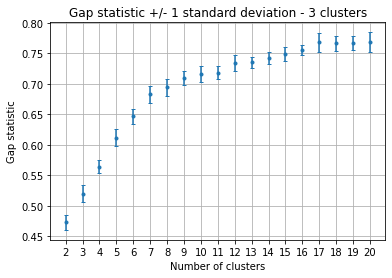

In [11]:
cmax = 20
GAP_OUT = np.zeros((cmax - 1, 2))
for i in np.arange(2, cmax + 1, 1):
    clusters = fcluster(clustering_2, i, criterion='maxclust')
    out = gap_stat('euclidean', 'ward', FACTORS.T, DIST_2, clusters, 20)
    GAP_OUT[i - 2, :] = [out[0], out[1]]

std_GAP = np.mean(GAP_OUT[:, 1])

N_CLUSTER = 2
for i in np.arange(2, cmax + 1, 1):
    if GAP_OUT[i - 2, 0] > (GAP_OUT[i - 3, 0] - std_GAP):
        N_CLUSTER = i
        break
        
        
# Plot the Gap Statistic results
plt.figure()
plt.errorbar(np.arange(2, cmax + 1, 1), GAP_OUT[:, 0], yerr=GAP_OUT[:, 1], capsize=2, fmt='.')
plt.title("Gap statistic +/- 1 standard deviation - %i clusters" % N_CLUSTER)
plt.xticks(np.arange(2, cmax + 1, 1))
plt.xlabel('Number of clusters')
plt.ylabel('Gap statistic')
plt.grid(True)
plt.savefig('gap_stat.jpeg',bbox_inches='tight', dpi=300)

plt.show()

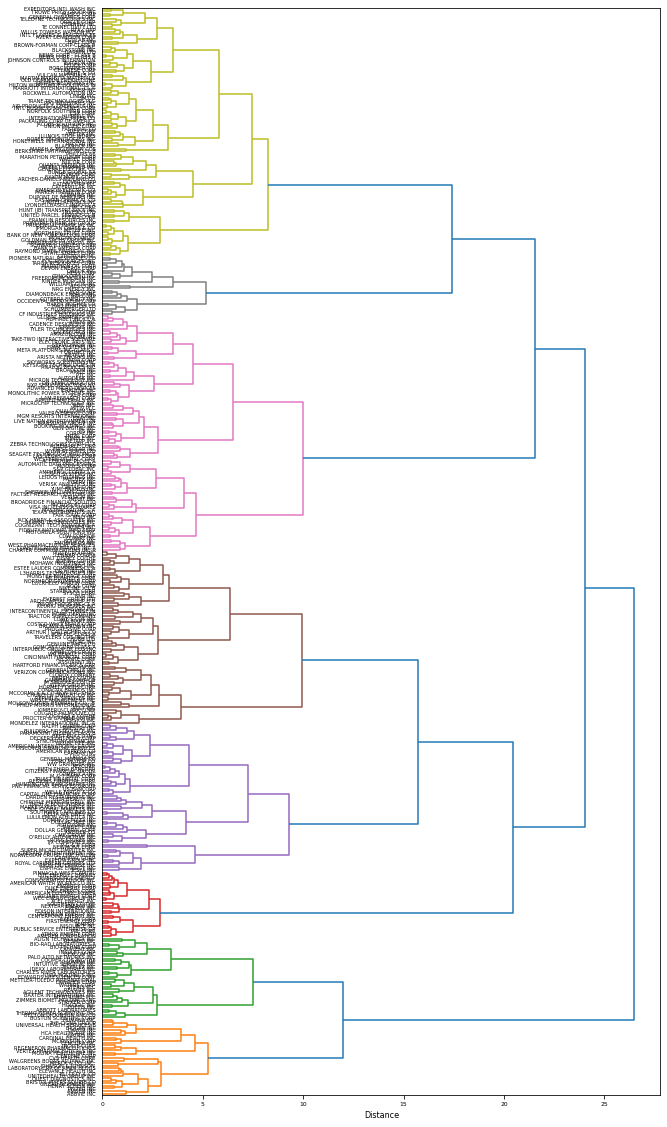

In [12]:
plt.figure(figsize=(10, 20))
csfont = {'fontname':'DejaVu Sans', 'fontsize' : '10'}
csfont2 = {'fontname':'DejaVu Sans', 'fontsize' : '8'}
csfont3 = {'fontname':'DejaVu Sans', 'fontsize' : '6'}
plt.xlabel('Distance',**csfont2)
plt.xticks(**csfont3)
plt.yticks(**csfont3)
dendrogram(clustering_2,color_threshold=11,truncate_mode='level',orientation='right',leaf_font_size=5,labels=NAMES_SELECT)
plt.savefig('books_read.jpeg',bbox_inches='tight', dpi=300)
plt.show()

### Step 2: For each cluster of stocks, extract the most important risk factor (the first eigen-portfolio from PCA).

In [13]:
# Step 2: Extract the most important risk factor for each cluster
n_clusters = 7  # Number of clusters you want
clusters = fcluster(clustering_2, n_clusters, criterion='maxclust')

# Extracting the most important risk factor for each cluster
for cluster_num in range(1, n_clusters+1):
    cluster_indices = np.where(clusters == cluster_num)[0]
    cluster_factors = FACTORS[cluster_indices, :]
    
    # Calculate the first eigen-portfolio (most important risk factor) for this cluster
    pca_cluster = PCA(cluster_factors)
    first_eigen_portfolio = pca_cluster.loadings[:, 0]  # Extract the first eigen-portfolio
    
    # Do something with the first eigen-portfolio, like print or store it
    print(f"Cluster {cluster_num}: Most important risk factor (first eigen-portfolio): {first_eigen_portfolio}")

Cluster 1: Most important risk factor (first eigen-portfolio): [-0.53058654  0.52753885 -0.0284376   0.56802408 -0.34164402]
Cluster 2: Most important risk factor (first eigen-portfolio): [-0.45842048  0.03886391  0.49510752  0.50920267  0.5328428 ]
Cluster 3: Most important risk factor (first eigen-portfolio): [-0.48555273  0.27512586  0.51683424 -0.461017    0.45704487]
Cluster 4: Most important risk factor (first eigen-portfolio): [0.25430585 0.51903854 0.56642266 0.39358294 0.43610248]
Cluster 5: Most important risk factor (first eigen-portfolio): [ 0.12695331  0.29582935  0.4834674  -0.56369478  0.58726086]
Cluster 6: Most important risk factor (first eigen-portfolio): [ 0.43814462 -0.24263768 -0.4953122  -0.54744189 -0.45180688]
Cluster 7: Most important risk factor (first eigen-portfolio): [-0.56941735 -0.0232677   0.71514876 -0.13694253  0.38083   ]


### Step 3: Spread estimation and spread update 

In [14]:
target_month = [i for i in range(1, 13)]
target_year = [i for i in range(2020, 2025)]

# Step 3.1: Define Constants and Parameters

T = []
dates_in_month = [date for date in dates if date.year == 2019 and date.month == 12]
# Get the number of days in the current month
num_days_in_month = len(dates_in_month)
# Append the number of days to the list
T.append(num_days_in_month)
# Define the estimation window (T trading days)


# Get the last date in the dates array
last_date = dates.iloc[-1]
last_year = last_date.year
last_month = last_date.month

# Iterate over each unique month and year
for year in target_year:
    for month in target_month:
        # Check if the current year and month are within the bounds of available data
        if year > last_year or (year == last_year and month > last_month):
            break
        # Find all dates in the dates list that belong to the current month and year
        dates_in_month = [date for date in dates if date.year == year and date.month == month]
        # Get the number of days in the current month
        num_days_in_month = len(dates_in_month)
        # Append the number of days to the list
        T.append(num_days_in_month)

# Print the list of the number of days for each month
print("List of the number of days for each month:")
print(T)


List of the number of days for each month:
[22, 23, 20, 22, 22, 21, 22, 23, 21, 22, 22, 21, 23, 21, 20, 23, 22, 21, 22, 22, 22, 22, 21, 22, 23, 21, 20, 23, 21, 22, 22, 21, 23, 22, 21, 22, 22, 22, 20, 23, 20, 23, 22, 21, 23, 21, 22, 22, 21, 23, 21, 21, 22, 2]


In [15]:
# Define the last trading day of the previous month
last_trading_day_prev_month = []
for year in target_year:
    for month in target_month:
        # Find the last trading day of the previous month
        last_day_of_prev_month = dt.datetime(year, month, 1) - dt.timedelta(days=1)
        # Append it to the list
        last_trading_day_prev_month.append(last_day_of_prev_month)

t_star_index = []
for last_trading_day in last_trading_day_prev_month:
    # Convert the last trading day to the string format used in the dates index
    last_trading_day_str = last_trading_day.strftime('%Y-%m-%d')
    # Find the index in the dates index
    index = dates[dates == last_trading_day_str].index
    # Keep decreasing by one day until a matching index is found
    while len(index) == 0:
        last_trading_day -= dt.timedelta(days=1)
        last_trading_day_str = last_trading_day.strftime('%Y-%m-%d')
        index = dates[dates == last_trading_day_str].index
    # Append the index to the list
    t_star_index.append(index[0])

# Print the indices found
print("Indices of the last trading day of the previous month:")
print(t_star_index)

Indices of the last trading day of the previous month:
[1303, 1326, 1346, 1368, 1390, 1411, 1433, 1456, 1477, 1499, 1521, 1542, 1565, 1586, 1606, 1629, 1651, 1672, 1694, 1716, 1738, 1760, 1781, 1803, 1826, 1847, 1867, 1890, 1911, 1933, 1955, 1976, 1999, 2021, 2042, 2064, 2086, 2108, 2128, 2151, 2171, 2194, 2216, 2237, 2260, 2281, 2303, 2325, 2346, 2369, 2390, 2411, 2433, 2435, 2435, 2435, 2435, 2435, 2435, 2435]


In [16]:
# Step 3.2 - Estimation of a and b
# Initialize arrays to store the estimated parameters and residuals
a_hat = np.zeros((len(T), n_stocks))
b_hat = np.zeros((len(T), n_stocks))
residuals_all = []

PCA_returns = RETURNS.dot(FACTORS)  # Shape: (2435, 5)

# Loop over each period length in T
for i in range(1,len(T)-1):
    t = T[i-1]
    residuals = np.zeros((t, n_stocks))

    for cluster_num in range(1, n_clusters + 1):
        cluster_indices = np.where(clusters == cluster_num)[0]
        cluster_factors = FACTORS[cluster_indices, :]

        # Perform PCA on the factors for the current cluster
        pca_cluster = PCA(cluster_factors)
        main_eigen_portfolio = pca_cluster.loadings[:, 0]

        for stock_idx in cluster_indices:
            # Define the estimation window
            start_idx = t_star_index[i+1] - t + 1
            end_idx = t_star_index[i+1] + 1

            if start_idx < 0:
                print(f"Skipping period length {t} for stock {stock_idx} due to insufficient data.")
                continue

            returns_window = RETURNS_NORM[start_idx:end_idx, stock_idx] 
            main_portfolio_returns_cluster = PCA_returns[start_idx:end_idx, :].dot(main_eigen_portfolio)

            if len(main_portfolio_returns_cluster) != len(returns_window):
                print(f"Skipping stock {stock_idx} due to mismatched dimensions in period {i+1}.")
                continue

            # Perform linear regression
            X = sm.add_constant(main_portfolio_returns_cluster)
            model = sm.OLS(returns_window, X).fit()

            # Store the estimated parameters
            a_hat[i+1, stock_idx] = model.params[0]
            if len(model.params) > 1:
                b_hat[i+1, stock_idx] = model.params[1]

            # Calculate residuals for the estimation window
            residuals[:len(model.resid), stock_idx] = model.resid

    # Store the residuals for all stocks for the current period length
    residuals_all.append(residuals)

# Print the estimated parameters
print("Estimated a_hat:")
print(a_hat)
print("Estimated b_hat:")
print(b_hat)

# Optionally, print residuals for inspection
for i, residuals in enumerate(residuals_all):
    print(f"Residuals for period length {T[i]}:")
    print(residuals)


Estimated a_hat:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.14267644 -0.14012582  0.11626915 ... -0.14699267 -0.0370766
  -0.08265531]
 ...
 [ 0.26466041 -0.05428209 -0.03002794 ...  0.1839653   0.20488036
   0.38694367]
 [ 0.18529132 -0.2606201  -0.16133825 ... -0.01242433  0.09073536
   0.07054689]
 [ 0.28106276 -0.32971943 -0.1690573  ... -0.00135433  0.1184957
   0.11657239]]
Estimated b_hat:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.19340959 -0.19764539 -0.08897943 ... -0.00764158  0.1655763
   0.20134752]
 ...
 [-0.12712063 -0.42750999 -0.26815152 ...  0.02232056 -0.25868424
  -0.45461371]
 [-0.35813189 -0.08525773 -0.35892745 ... -0.12639971 -0.22228597
  -0.07298885]
 [-0.35814083 -0.0700017  -0.34345285 ... -0.09444303 -0.16059011
   0.05655396]]
Residuals for per

In [17]:
# Step 3.3: Calculate the Spread over the Estimation Period
# Initialize array to store the spread for each period length in T
spread_estimation_period = np.zeros((len(T), n_stocks))

# Loop over each period length in T and calculate the spread
for i in range(1, len(T)-1):
    # Sum the residuals over the estimation window for each stock
    spread_estimation_period[i-1, :] = np.sum(residuals_all[i-1], axis=0)

# Print the spread for inspection
print("Spread over the estimation periods:")
print(spread_estimation_period)


Spread over the estimation periods:
[[ 0.00000000e+00 -6.66133815e-16  1.33226763e-15 ...  0.00000000e+00
   4.44089210e-16  0.00000000e+00]
 [ 2.66453526e-15  3.77475828e-15  1.44328993e-15 ... -1.77635684e-15
  -2.66453526e-15 -3.55271368e-15]
 [-1.88737914e-15  0.00000000e+00  1.66533454e-15 ...  8.88178420e-16
  -6.66133815e-16  3.10862447e-15]
 ...
 [ 2.88657986e-15 -4.55191440e-15 -1.49880108e-15 ... -1.02001740e-15
   2.49800181e-16  1.22124533e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [18]:
# Step 3.4: Forecast the Spread for the Target Month
# Initialize array to store the forecasted spread
forecasted_spread = np.zeros((len(T), n_stocks))

for i, t in enumerate(T):
    if i == len(T) - 1:  # Skip forecast for the last month
        print("Skipping forecast for the last month.")
        continue
    
    for cluster_num in range(1, n_clusters + 1):
        cluster_indices = np.where(clusters == cluster_num)[0]
        cluster_factors = FACTORS[cluster_indices, :]

        # Perform PCA on the factors for the current cluster
        pca_cluster = PCA(cluster_factors)
        main_eigen_portfolio = pca_cluster.loadings[:, 0]

        for stock_idx in cluster_indices:
            # Define the forecast window
            start_idx = t_star_index[i] + 1
            end_idx = t_star_index[i] + t + 1

            if end_idx >= len(RETURNS_NORM):
                print(f"Skipping period length {t} for stock {stock_idx} due to insufficient data for forecasting.")
                continue

            returns_window_forecast = RETURNS_NORM[start_idx:end_idx, stock_idx]
            main_portfolio_returns_cluster_forecast = PCA_returns[start_idx:end_idx, :].dot(main_eigen_portfolio)

            if len(main_portfolio_returns_cluster_forecast) != len(returns_window_forecast):
                print(f"Skipping stock {stock_idx} due to mismatched dimensions in forecast period {i}.")
                continue

            # Forecast the residuals using the estimated parameters
            forecasted_residuals = returns_window_forecast - (a_hat[i, stock_idx] + b_hat[i, stock_idx] * main_portfolio_returns_cluster_forecast)

            # Sum the forecasted residuals to calculate the spread for the forecast period
            forecasted_spread[i, stock_idx] = np.sum(forecasted_residuals)

# Print the forecasted spread for inspection
print("Forecasted spread for the target month:")
print(forecasted_spread)


Skipping period length 22 for stock 96 due to insufficient data for forecasting.
Skipping period length 22 for stock 195 due to insufficient data for forecasting.
Skipping period length 22 for stock 196 due to insufficient data for forecasting.
Skipping period length 22 for stock 197 due to insufficient data for forecasting.
Skipping period length 22 for stock 198 due to insufficient data for forecasting.
Skipping period length 22 for stock 199 due to insufficient data for forecasting.
Skipping period length 22 for stock 200 due to insufficient data for forecasting.
Skipping period length 22 for stock 201 due to insufficient data for forecasting.
Skipping period length 22 for stock 202 due to insufficient data for forecasting.
Skipping period length 22 for stock 203 due to insufficient data for forecasting.
Skipping period length 22 for stock 204 due to insufficient data for forecasting.
Skipping period length 22 for stock 205 due to insufficient data for forecasting.
Skipping period l

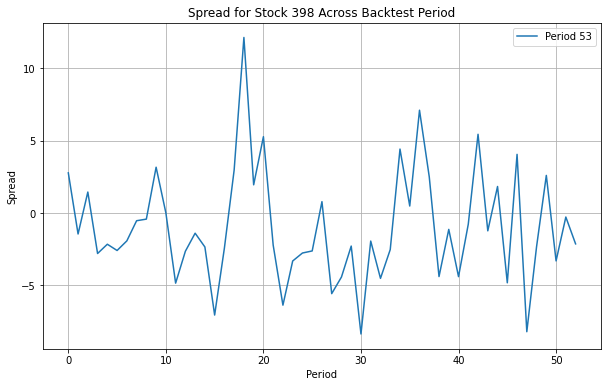

In [19]:
# Select the stock for which you want to plot the spread
stock=list()

# Plot the spread for the selected stock across the backtest period
plt.figure(figsize=(10, 6))
for i, t in enumerate(T):
    if i == len(T) - 1:  # Skip the last month
        continue
    stock.append(forecasted_spread[0, i]) 

plt.plot(stock, label=f"Period {i}")
plt.title(f"Spread for Stock {stock_idx} Across Backtest Period")
plt.xlabel("Period")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()


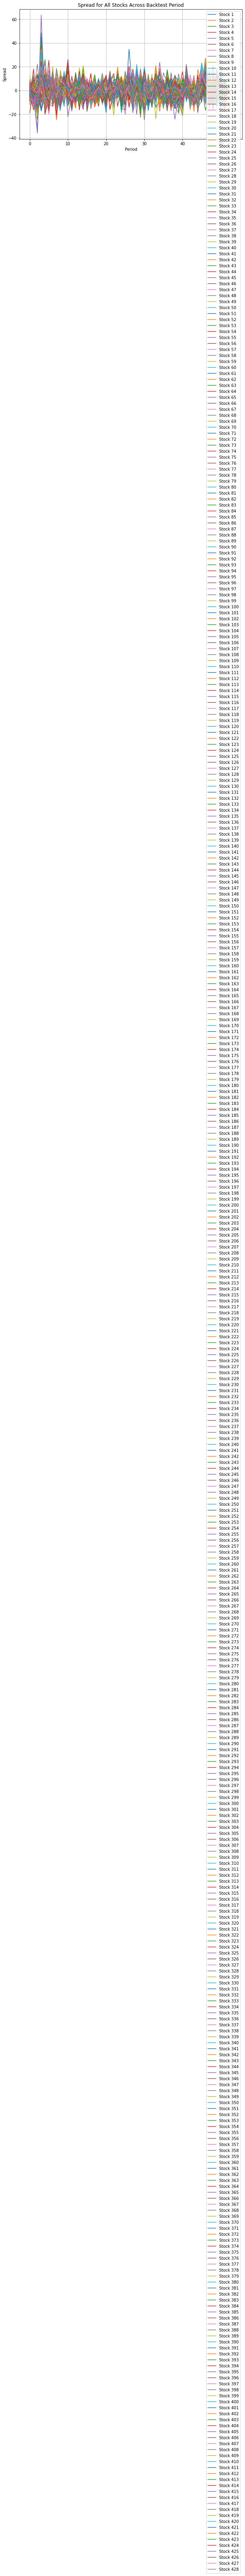

In [20]:
# Initialize an array to store spread results for all stocks
spread_all_stocks = np.zeros((len(T), n_stocks))

# Store spread results for all stocks
for j in range(n_stocks):
    for i, t in enumerate(T):
        if i == len(T) - 1:  # Skip the last month
            continue
        spread_all_stocks[i, j] = forecasted_spread[i, j]

# Plot the spread for all stocks across the backtest period
plt.figure(figsize=(10, 6))

for j in range(n_stocks):
    plt.plot(spread_all_stocks[:, j], label=f"Stock {j+1}")

plt.title("Spread for All Stocks Across Backtest Period")
plt.xlabel("Period")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()


### Step 4: Determination of trading signals

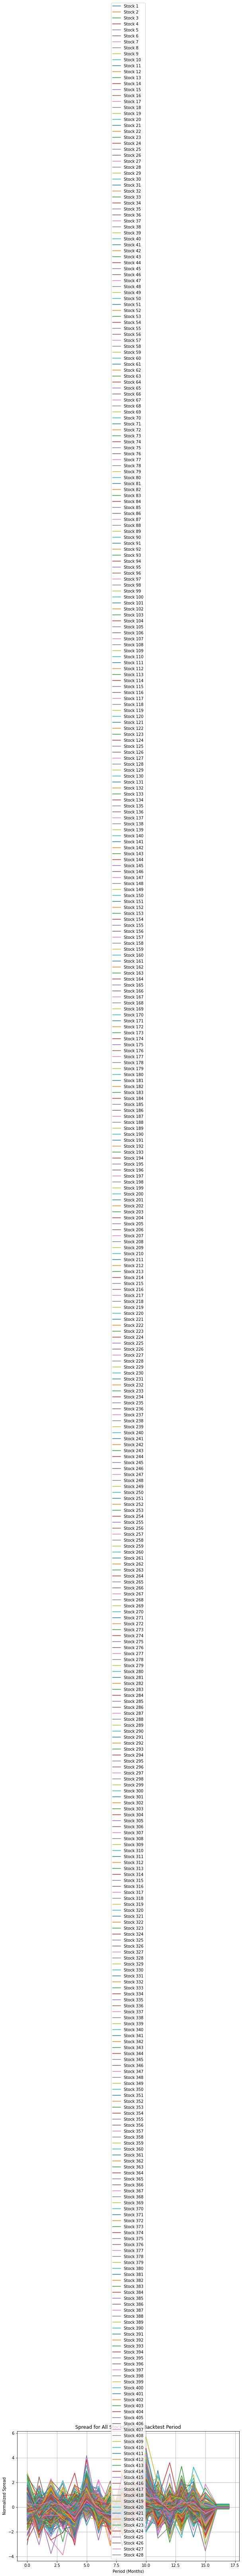

In [21]:
length_estimation_window = [252, 504, 800]
date_start_test = length_estimation_window[2]  

# Calculate the cumulative sum of days
cumulative_days = np.cumsum(T)

# Find the starting month for the backtest period
start_month_idx = np.searchsorted(cumulative_days, date_start_test, side='right')

# Define the backtest period in months
backtest_period_monthly = len(T) - start_month_idx

# Normalize the spread for all stocks
#backtest_start_day = cumulative_days[start_month_idx]
mean_ = [np.mean(spread_all_stocks[:start_month_idx-1, :], axis=0)]*backtest_period_monthly
std_ = [np.std(spread_all_stocks[:start_month_idx-1, :], axis=0)]*backtest_period_monthly

spread_normalized_all_stocks = (spread_all_stocks[start_month_idx:, :] - mean_)/std_
# Plot the normalized spread for all stocks
plt.figure(figsize=(10, 6))

for j in range(n_stocks):
    plt.plot(spread_normalized_all_stocks[:, j], label=f"Stock {j+1}")

plt.title("Spread for All Stocks Across Backtest Period")
plt.xlabel("Period (Months)")
plt.ylabel("Normalized Spread")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
#np.savetxt("normalized_spread_forecasted.csv", spread_normalized_all_stocks, delimiter=",",header = None, comments='', fmt='%.2f')


In [23]:
def determine_trading_signals(spread_normalized, 
                              ShortStop, ShortOpen, ShortClose, 
                              LongClose, LongOpen, LongStop):
    """
    Determines trading signals based on normalized spreads and specified thresholds.

    Parameters:
    spread_normalized_all_stocks (np.ndarray): Normalized spread data (time x stocks).
    ShortOpen (float): Threshold to open a short position.
    ShortStop (float): Stop-loss threshold for a short position.
    ShortClose (float): Threshold to close a short position.
    LongOpen (float): Threshold to open a long position.
    LongStop (float): Stop-loss threshold for a long position.
    LongClose (float): Threshold to close a long position.

    Returns:
    short_signals (np.ndarray): Array of short trading signals (time x stocks).
    long_signals (np.ndarray): Array of long trading signals (time x stocks).
    """
    n_periods, n_stocks = spread_normalized.shape

    # Initialize arrays to store trading signals
    short_signals = np.zeros((n_periods, n_stocks))
    long_signals = np.zeros((n_periods, n_stocks))

    # Generate trading signals based on the normalized spread
    for j in range(n_stocks):
        for i in range(n_periods - 1):  # Skip the last month
            S_star_t = spread_normalized_all_stocks[i, j]
            
            # Determine short signals
            if ShortStop > S_star_t > ShortOpen:
                short_signals[i, j] = -1  # Open short position
            elif S_star_t > ShortStop or S_star_t < ShortClose:
                short_signals[i, j] = 1  # Close short position

            # Determine long signals
            if LongOpen < S_star_t < LongStop:
                long_signals[i, j] = 1  # Open long position
            elif S_star_t < LongStop or S_star_t > LongClose:
                long_signals[i, j] = -1  # Close long position

    return short_signals, long_signals

In [24]:
strat1 = determine_trading_signals(spread_normalized_all_stocks, 2.5, 1.5, 0.5, -0.5, -1.5, -2.5)
strat1

strat2 = determine_trading_signals(spread_normalized_all_stocks, 2, 1, 0.1, -0.1, -1, -2)
strat2

strat3 = determine_trading_signals(spread_normalized_all_stocks, 3.2, 1.8, 0.8, -0.6, -1.6, -2.8)
strat3
#spread_normalized_all_stocks
#setup1 = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
#setup3 = [2, 1, 0.1, -0.1, -1, -2]

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 0., ..., 0., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[-1., -1., -1., ...,  0., -1., -1.],
        [ 0., -1.,  0., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ...,  0., -1.,  0.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]))

### Step 5: Performance update

In [25]:
def compute_cluster_benchmark_returns(returns, clusters, n_clusters):
    """
    Compute the daily return of each cluster benchmark.

    Parameters:
    returns (np.ndarray): Array of stock returns (time x stocks).
    clusters (np.ndarray): Array indicating the cluster of each stock (length n_stocks).
    n_clusters (int): Number of clusters.

    Returns:
    cluster_benchmark_returns (np.ndarray): Array of cluster benchmark returns (time x n_clusters).
    """
    n_periods = returns.shape[0]
    cluster_benchmark_returns = np.zeros((n_periods, n_clusters))

    for cluster_num in range(1, n_clusters + 1):
        cluster_indices = np.where(clusters == cluster_num)[0]
        cluster_benchmark_returns[:, cluster_num - 1] = np.mean(returns[:, cluster_indices], axis=1)

    return cluster_benchmark_returns

def compute_spread_returns(returns, cluster_benchmark_returns, clusters, short_signals, long_signals, estimation_window):
    """
    Compute the spread returns aggregated over the estimation window.

    Parameters:
    returns (np.ndarray): Array of stock returns (time x stocks).
    cluster_benchmark_returns (np.ndarray): Array of cluster benchmark returns (time x n_clusters).
    clusters (np.ndarray): Array indicating the cluster of each stock (length n_stocks).
    short_signals (np.ndarray): Array of short trading signals (months x stocks).
    long_signals (np.ndarray): Array of long trading signals (months x stocks).
    estimation_window (list): List of estimation window lengths (days) for each month.

    Returns:
    spread_returns (np.ndarray): Array of spread returns (months x stocks).
    """
    n_days, n_stocks = returns.shape
    n_months = len(estimation_window)
    spread_returns = np.zeros((n_months, n_stocks))

    # Track the state of positions (1 for long, -1 for short, 0 for no position)
    position_state = np.zeros(n_stocks)

    for month in range(n_months):
        start_idx = sum(estimation_window[:month])
        end_idx = start_idx + estimation_window[month]
        
        if end_idx > n_days:
            print(f"Skipping month {month} due to insufficient data for forecasting.")
            continue

        for j in range(n_stocks):
            cluster_num = clusters[j]
            stock_return = returns[start_idx+1:end_idx, j]
            cluster_return = cluster_benchmark_returns[start_idx+1:end_idx, cluster_num - 1]

            if short_signals[month, j] == -1:  # Short position opened
                position_state[j] = -1
            elif long_signals[month, j] == 1:  # Long position opened
                position_state[j] = 1
            elif short_signals[month, j] == 1:  # Short position closed
                position_state[j] = 0
            elif long_signals[month, j] == -1:  # Long position closed
                position_state[j] = 0

            if position_state[j] == -1:  # Short position
                stock_cum_return = (1+ pd.DataFrame(stock_return)).cumprod().iloc[-1,:] - 1
                cluster_cum_return = (1+pd.DataFrame(cluster_return)).cumprod().iloc[-1,:] - 1
                spread_returns[month, j] = stock_cum_return - cluster_cum_return
            elif position_state[j] == 1:  # Long position
                stock_cum_return = (1+ pd.DataFrame(stock_return)).cumprod().iloc[-1,:] - 1
                cluster_cum_return = (1+pd.DataFrame(cluster_return)).cumprod().iloc[-1,:] - 1
                spread_returns[month, j] = cluster_cum_return - stock_cum_return
            else:
                spread_returns[month, j] = 0  # Neutral position

    return spread_returns

def compute_global_portfolio_return(spread_returns):
    """
    Compute the daily return of the global portfolio as the average of the traded spread returns.

    Parameters:
    spread_returns (np.ndarray): Array of spread returns (time x stocks).

    Returns:
    global_portfolio_return (np.ndarray): Array of global portfolio returns (time).
    """
    global_portfolio_return = np.zeros(spread_returns.shape[0])

    for i in range(spread_returns.shape[0]):
        non_zero_spreads = spread_returns[i][spread_returns[i] != 0]
        if len(non_zero_spreads) > 0:
            global_portfolio_return[i] = np.mean(non_zero_spreads)
        else:
            global_portfolio_return[i] = 0

    return global_portfolio_return


### Strat1

In [26]:
def get_next_month_start(date, dates):
    next_month_start = (date.replace(day=1) + pd.DateOffset(months=1)).replace(day=1)
    while next_month_start not in dates.values:
        next_month_start += pd.DateOffset(days=1)
    return next_month_start


backtest_start_date = dates.iloc[1304+date_start_test]
if backtest_start_date.day != 1:
    backtest_start_date = get_next_month_start(backtest_start_date, dates)
    start_backtest = dates[dates == backtest_start_date].index[0]


In [27]:
# Compute cluster benchmark returns
short_signals = strat1[0]
long_signals = strat1[1]

n_clusters = 7  
#start_backtest = 1304+date_start_test
cluster_benchmark_returns = compute_cluster_benchmark_returns(RETURNS[start_backtest:], clusters, n_clusters)

spread_returns = compute_spread_returns(RETURNS[start_backtest:], cluster_benchmark_returns, clusters, short_signals, long_signals, T[1:])

global_portfolio_return = compute_global_portfolio_return(spread_returns[:len(T[1:]) - start_month_idx])

Skipping month 15 due to insufficient data for forecasting.
Skipping month 16 due to insufficient data for forecasting.
Skipping month 17 due to insufficient data for forecasting.
Skipping month 18 due to insufficient data for forecasting.
Skipping month 19 due to insufficient data for forecasting.
Skipping month 20 due to insufficient data for forecasting.
Skipping month 21 due to insufficient data for forecasting.
Skipping month 22 due to insufficient data for forecasting.
Skipping month 23 due to insufficient data for forecasting.
Skipping month 24 due to insufficient data for forecasting.
Skipping month 25 due to insufficient data for forecasting.
Skipping month 26 due to insufficient data for forecasting.
Skipping month 27 due to insufficient data for forecasting.
Skipping month 28 due to insufficient data for forecasting.
Skipping month 29 due to insufficient data for forecasting.
Skipping month 30 due to insufficient data for forecasting.
Skipping month 31 due to insufficient da

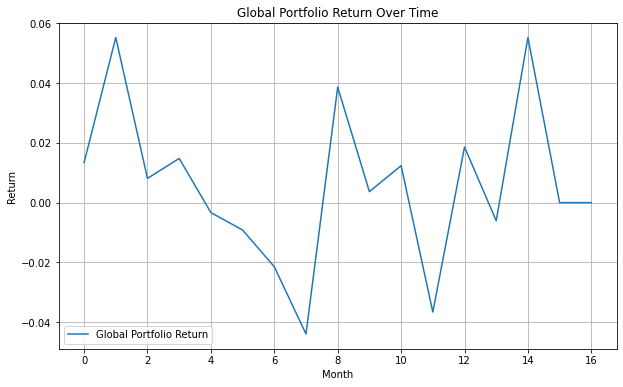

In [28]:
# Plot the global portfolio return
plt.figure(figsize=(10, 6))
plt.plot(global_portfolio_return, label="Global Portfolio Return")
plt.title("Global Portfolio Return Over Time")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

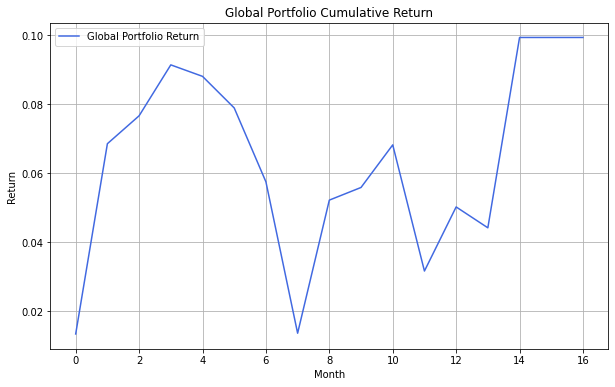

In [29]:
# Plot the global portfolio return
plt.figure(figsize=(10, 6))
plt.plot(global_portfolio_return.cumsum(), label="Global Portfolio Return", color = 'royalblue')
plt.title("Global Portfolio Cumulative Return")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.savefig('Global_Portfolio_Cumulative_Return_S1.png')
plt.show()

### Strat2

In [30]:
# Compute cluster benchmark returns
short_signals = strat2[0]
long_signals = strat2[1]

n_clusters = 7  # example number of clusters
#start_backtest = 1304+date_start_test
cluster_benchmark_returns2 = compute_cluster_benchmark_returns(RETURNS[start_backtest:], clusters, n_clusters)

# Compute spread returns
spread_returns2 = compute_spread_returns(RETURNS[start_backtest:], cluster_benchmark_returns2, clusters, short_signals, long_signals, T[1:])

# Compute global portfolio return
global_portfolio_return2 = compute_global_portfolio_return(spread_returns2[:len(T[1:]) - start_month_idx])

Skipping month 15 due to insufficient data for forecasting.
Skipping month 16 due to insufficient data for forecasting.
Skipping month 17 due to insufficient data for forecasting.
Skipping month 18 due to insufficient data for forecasting.
Skipping month 19 due to insufficient data for forecasting.
Skipping month 20 due to insufficient data for forecasting.
Skipping month 21 due to insufficient data for forecasting.
Skipping month 22 due to insufficient data for forecasting.
Skipping month 23 due to insufficient data for forecasting.
Skipping month 24 due to insufficient data for forecasting.
Skipping month 25 due to insufficient data for forecasting.
Skipping month 26 due to insufficient data for forecasting.
Skipping month 27 due to insufficient data for forecasting.
Skipping month 28 due to insufficient data for forecasting.
Skipping month 29 due to insufficient data for forecasting.
Skipping month 30 due to insufficient data for forecasting.
Skipping month 31 due to insufficient da

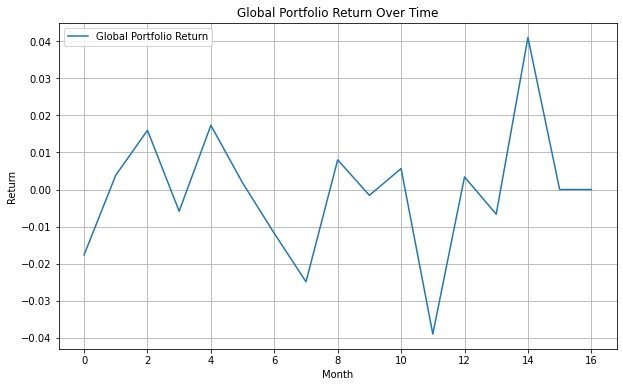

In [31]:
# Plot the global portfolio return
plt.figure(figsize=(10, 6))
plt.plot(global_portfolio_return2, label="Global Portfolio Return")
plt.title("Global Portfolio Return Over Time")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

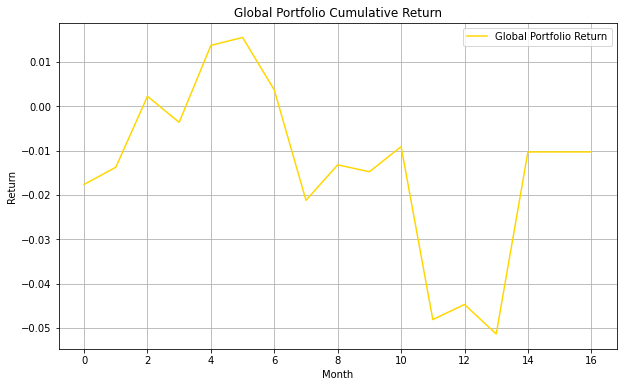

In [32]:
# Plot the global portfolio return
plt.figure(figsize=(10, 6))
plt.plot(global_portfolio_return2.cumsum(), label="Global Portfolio Return", color = 'gold')
plt.title("Global Portfolio Cumulative Return")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.savefig('Global_Portfolio_Cumulative_Return_S2.png')  # You can specify the format by changing the file extension
plt.show()

# Strat 3

In [33]:
# Compute cluster benchmark returns
short_signals = strat3[0]
long_signals = strat3[1]

n_clusters = 7  # example number of clusters
#start_backtest = 1304+date_start_test
cluster_benchmark_returns3 = compute_cluster_benchmark_returns(RETURNS[start_backtest:], clusters, n_clusters)

# Compute spread returns
spread_returns3 = compute_spread_returns(RETURNS[start_backtest:], cluster_benchmark_returns3, clusters, short_signals, long_signals, T[1:])

# Compute global portfolio return
global_portfolio_return3 = compute_global_portfolio_return(spread_returns3[:len(T[1:]) - start_month_idx])

Skipping month 15 due to insufficient data for forecasting.
Skipping month 16 due to insufficient data for forecasting.
Skipping month 17 due to insufficient data for forecasting.
Skipping month 18 due to insufficient data for forecasting.
Skipping month 19 due to insufficient data for forecasting.
Skipping month 20 due to insufficient data for forecasting.
Skipping month 21 due to insufficient data for forecasting.
Skipping month 22 due to insufficient data for forecasting.
Skipping month 23 due to insufficient data for forecasting.
Skipping month 24 due to insufficient data for forecasting.
Skipping month 25 due to insufficient data for forecasting.
Skipping month 26 due to insufficient data for forecasting.
Skipping month 27 due to insufficient data for forecasting.
Skipping month 28 due to insufficient data for forecasting.
Skipping month 29 due to insufficient data for forecasting.
Skipping month 30 due to insufficient data for forecasting.
Skipping month 31 due to insufficient da

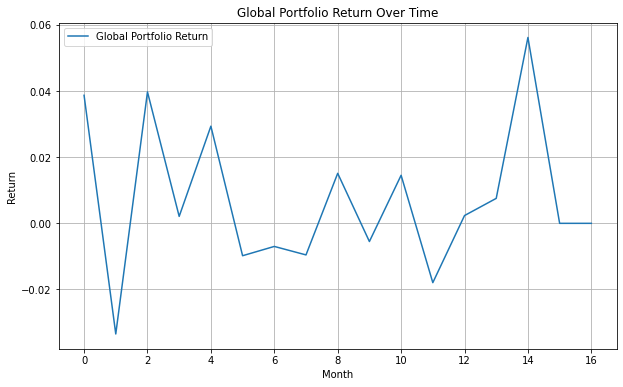

In [34]:
# Plot the global portfolio return
plt.figure(figsize=(10, 6))
plt.plot(global_portfolio_return3, label="Global Portfolio Return")
plt.title("Global Portfolio Return Over Time")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

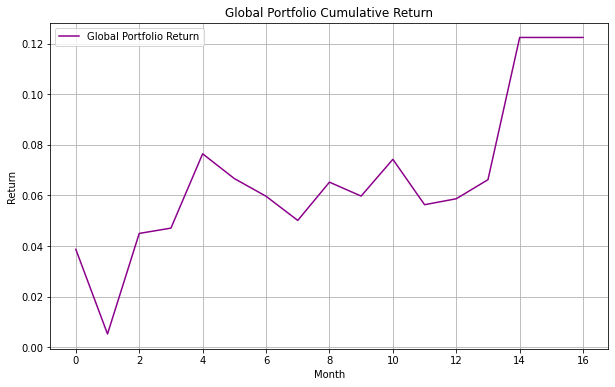

In [35]:
# Plot the global portfolio return
plt.figure(figsize=(10, 6))
plt.plot(global_portfolio_return3.cumsum(), label="Global Portfolio Return", color = 'darkmagenta')
plt.title("Global Portfolio Cumulative Return")
plt.xlabel("Month")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.savefig('Global_Portfolio_Cumulative_Return_S2.png')  # You can specify the format by changing the file extension
plt.show()

### Risk metrics

In [36]:
def compute_performance_metrics(global_portfolio_return):
    """
    Compute the performance metrics for the global portfolio return.

    Parameters:
    global_portfolio_return (np.ndarray): Array of global portfolio returns (months).

    Returns:
    dict: A dictionary containing the performance metrics.
    """
    metrics = {}
    risk_free_rate = 0

    # Annualized Return
    average_return = np.mean(global_portfolio_return)
    annualized_return = (1 + average_return)**12 - 1
    metrics['Annualized Return'] = annualized_return

    # Annualized Volatility
    std_dev_return = np.std(global_portfolio_return)
    annualized_volatility = std_dev_return * np.sqrt(12)
    metrics['Annualized Volatility'] = annualized_volatility
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    metrics['Sharpe Ratio'] = sharpe_ratio

    # Maximum Drawdown
    cumulative_returns = np.cumprod(1 + global_portfolio_return) - 1
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdown = rolling_max - cumulative_returns
    max_drawdown = np.max(drawdown)
    metrics['Maximum Drawdown'] = max_drawdown

    # Expected Shortfall (ES) at 95% confidence level
    var_95 = np.percentile(global_portfolio_return, 5)
    es_95 = np.mean(global_portfolio_return[global_portfolio_return <= var_95])
    metrics['Expected Shortfall (95%)'] = es_95

    return metrics



In [37]:
performance_metrics = compute_performance_metrics(global_portfolio_return)

# Print the performance metrics
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.4f}")

Annualized Return: 0.0725
Annualized Volatility: 0.0915
Sharpe Ratio: 0.7925
Maximum Drawdown: 0.0833
Expected Shortfall (95%): -0.0439


In [38]:
performance_metrics = compute_performance_metrics(global_portfolio_return2)

# Print the performance metrics
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.4f}")

Annualized Return: -0.0073
Annualized Volatility: 0.0596
Sharpe Ratio: -0.1217
Maximum Drawdown: 0.0668
Expected Shortfall (95%): -0.0390


In [39]:
performance_metrics = compute_performance_metrics(global_portfolio_return3)

# Print the performance metrics
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.4f}")

Annualized Return: 0.0899
Annualized Volatility: 0.0771
Sharpe Ratio: 1.1658
Maximum Drawdown: 0.0347
Expected Shortfall (95%): -0.0334
